# Analyze articles from mega journals

## Import packages


First, let us import all the packages, which are needed for this notebook:

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from crossref.restful import Works, Journals
from wordcloud import WordCloud

If you miss one of these packages, then you can also install it directly here with something like the following (don't forget to restart the kernel afterwards):

In [ ]:
!pip install crossrefapi wordcloud

## Choose the mega journal to analyze

For each mega journal a specific search within the CrossRef API is defined (see below).
You can choose the mega journal here from this list and then make the analysis for that.
The resulting figures and data are saved the the specified prefix then.

In [2]:
# You can change this to one of the values:
choice = "academia-letters"
#choice = "plos-one"
#choice = "peerj"
#choice = "peerj-cs"
#choice = "sage-open"
#choice = "open-research-europe"
#choice = "f1000-research"

prefix = choice + "-"

## Analyze the papers

This step relies on the previously created CSV files, where the data is from Crossref is saved.
If you want to take fresh data first, then jump to the section below.
Otherwise you can continue here to analyze the same data as it was used originally.

In [3]:
# reading csv file as pandas dataframe
data = pd.read_csv('./data/' + prefix + 'papers.csv')

data['issued'] = pd.to_datetime(data['issued'])
data['year'] = data['issued'].dt.year
data['month'] = data['issued'].dt.month
data['weekday'] = data['issued'].dt.weekday

# showing the first entries
data.head()

DOI    prefix  \
0  10.20935/al2610  10.20935   
1   10.20935/al953  10.20935   
2   10.20935/al106  10.20935   
3   10.20935/al421  10.20935   
4  10.20935/al3740  10.20935   

                                               title language  \
0  Florentino Ariza as a Machiavellian artist in ...       en   
1  A Novel Treatment Approach in Alzheimer’s Dise...       en   
2  Designing optimal welfare policies for interme...       en   
3  Back and Forth: The Journey of Inclusive Educa...       en   
4  A Proof of Concept Randomized Controlled Trial...       en   

    container-title       ISSN     publisher  \
0  Academia Letters        NaN  Academia.edu   
1  Academia Letters        NaN  Academia.edu   
2  Academia Letters  2771-9359  Academia.edu   
3  Academia Letters        NaN  Academia.edu   
4  Academia Letters        NaN  Academia.edu   

                                 URL     issued   published published-online  \
0  http://dx.doi.org/10.20935/al2610 2021-08-04    2021-8-4         2021-8-4   
1   http://dx.doi.org/10.20935/al953 2021-04-28   2021-4-28        2021-4-28   
2   http://dx.doi.org/10.20935/al106 2020-12-29  2020-12-29       2020-12-29   
3   http://dx.doi.org/10.20935/al421 2021-03-04    2021-3-4         2021-3-4   
4  http://dx.doi.org/10.20935/al3740 2021-10-20  2021-10-20       2021-10-20   

      indexed     created  reference-count  is-referenced-by-count  \
0   2021-12-8   2021-8-17                0                       0   
1  2021-12-12   2021-4-28                0                       0   
2   2022-3-13   2021-1-14                0                       1   
3  2021-12-18    2021-3-6                0                       0   
4   2021-12-9  2021-11-11                0                       0   

              type  member  year  month  weekday  
0  journal-article    9563  2021      8        2  
1  journal-article    9563  2021      4        2  
2  journal-article    9563  2020     12        1  
3  journal-article    9563  2021      3        3  
4  journal-article    9563  2021     10        2

In [4]:
# Some consistency and sanity checks
print(data['prefix'].value_counts(), "\n")
print(data['language'].value_counts(), "\n")
print(data['container-title'].value_counts(), "\n")
print(data['ISSN'].value_counts(), "\n")
print(data['publisher'].value_counts(), "\n")
print(data['type'].value_counts(), "\n")
print(data['member'].value_counts(), "\n")

10.20935    3895
Name: prefix, dtype: int64 

en    3895
Name: language, dtype: int64 

Academia Letters    3895
Name: container-title, dtype: int64 

2771-9359    3839
Name: ISSN, dtype: int64 

Academia.edu    3895
Name: publisher, dtype: int64 

journal-article    3895
Name: type, dtype: int64 

9563    3895
Name: member, dtype: int64 



### Publications per month

In [5]:
data['issued'].value_counts()
data.value_counts(subset=['year', 'month'], sort=False)

year  month
2020  9          1
      10         2
      11        21
      12        43
2021  1         97
      2        161
      3        388
      4         98
      5         26
      6        383
      7        953
      8        876
      9        163
      10       135
      11       182
      12       170
2022  1        160
      2         36
dtype: int64

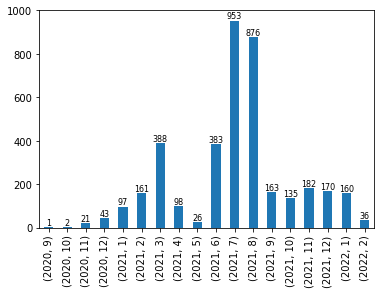

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

data.value_counts(subset=['year', 'month'], sort=False).plot(kind='bar', legend=False).set(xlabel=None)
# the following needs matplot 3.4.1 or higher
ax.bar_label(ax.containers[0], size=8)

plt.savefig('./figures/' + prefix + 'published-articles.png', dpi=600, bbox_inches="tight")

### Publications per weekday

In [7]:
data['weekday'].value_counts().sort_index()

0    644
1    553
2    809
3    760
4    493
5    374
6    262
Name: weekday, dtype: int64

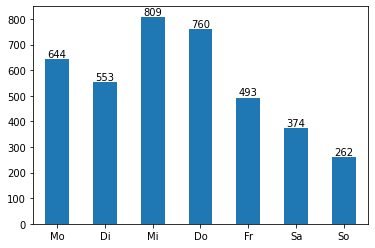

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

data['weekday'].value_counts().sort_index().rename(index={0: "Mo", 1: "Di", 2: "Mi", 3: "Do", 4: "Fr", 5: "Sa", 6: "So"}).plot(kind='bar')
plt.xticks(rotation=0)
# the following needs matplot 3.4.1 or higher
ax.bar_label(ax.containers[0])

plt.savefig('./figures/' + prefix + 'publications-weekday.png', dpi=600)

If articles are published on Sunday, this may indicate a (fully) automated publishing workflow.

### Word cloud from the title words

First, we concatenate the title of all published articles into one variable.

In [9]:
wordsFromTitles = ""
with open('./data/' + prefix + 'papers.csv', 'r', newline='') as papersfile:
    reader = csv.DictReader(papersfile)
    for row in reader:
        wordsFromTitles += row['title'] + " | "

# print(wordsFromTitles)

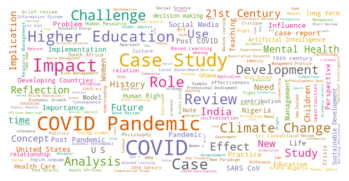

In [10]:
from wordcloud import WordCloud
#wordcloud = WordCloud().generate(wordsFromTitles)

wordcloud = WordCloud(max_font_size=50, collocation_threshold=5, background_color="white", colormap="Dark2", width=800, height=400).generate(wordsFromTitles)

# save it to a file
wordcloud.to_file('./figures/' + prefix + 'wordcloud.png')

# preview the cloud here directly
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some other results from the exploration phase is saved at the end of this notebook.

## Refetch and update the data (optional)

The data from CrossRef's API was fetched along these lines. You can refetch them respectively update the data.
All the data here will be saved as CSV files, such that afterwards you can re-analyze them by the code above.

In [12]:
works = Works()
journals = Journals()

if choice == "academia-letters": articles = works.filter(container_title="Academia Letters")
if choice == "plos-one": articles = journals.works('1932-6203').filter(from_issued_date='2021')
if choice == "peerj": articles = journals.works('2167-8359').filter(from_issued_date='2021')
if choice == "peerj-cs": articles = journals.works('2376-5992').filter(from_issued_date='2021')
if choice == "sage-open": articles = journals.works('2158-2440').filter(from_issued_date='2021')
if choice == "open-research-europe": articles = journals.works('2732-5121').filter(from_issued_date='2021')
if choice == "f1000-research": articles = journals.works('2046-1402').filter(from_issued_date='2021')

print(articles.count(), articles.url)

3900 https://api.crossref.org/works?filter=container-title%3AAcademia+Letters


In [13]:
def parse(key, obj):
    if key in obj:
        value = obj[key]
    else:
        return ''

    if key in ['issued', 'published', 'published-online', 'indexed', 'created']:
        # e.g. {"date-parts":[[2021,8,17]],"date-time":"2021-08-17T20:02:44Z","timestamp":1629230564000}
        if "date-parts" in value:
            return ", ".join(["-".join(map(str, date)) for date in value['date-parts']])
        else:
            print("WARNING: unexpected date format", value)

    if key in ['title', 'container-title']:
        if len(value) == 1:
            return(value[0])
        else:
            print("WARNING: unexpected title format", value)

    # ISSN is an array and we simply concatenate multiple values
    if key in ['ISSN']:
        return ", ".join(value)
    if key in ['affiliation']:
        return " + ".join([aff['name'] for aff in value])

    return value

In [14]:
fields = ['DOI', 'prefix', 'title', 'language', 'container-title', 'ISSN', 'publisher', 'URL', 'issued', 'published', 'published-online', 'indexed', 'created', 'reference-count', 'is-referenced-by-count', 'type', 'member']
with open('./data/' + prefix + 'papers.csv', 'w', newline='') as papersfile:
    paperswriter = csv.writer(papersfile)
    paperswriter.writerow(fields)

    author_fields = ['given', 'family', 'sequence', 'affiliation']
    with open('./data/' + prefix + 'authors.csv', 'w', newline='') as authorsfile:
        authorswriter = csv.writer(authorsfile)
        authorswriter.writerow(author_fields + ['DOI'])

        i=0
        for entry in articles:
            i += 1
            line = [parse(field, entry) for field in fields]
            paperswriter.writerow(line)

            if 'author' in entry:
                for author in entry['author']:
                    author_line = [parse(field, author) for field in author_fields]
                    author_line.append(entry['DOI'])
                    authorswriter.writerow(author_line)
            else:
                print("WARNING: no author info for", entry['DOI'], entry['title'])

            # For testing
            #if i > 3: break


## Other things from the exploration phase

### Citation distribution

0    0.976380
1    0.020026
2    0.002824
3    0.000257
4    0.000257
6    0.000257
Name: is-referenced-by-count, dtype: float64


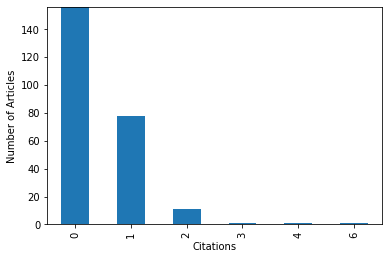

In [15]:
# print(data['reference-count'].value_counts())
citations = data['is-referenced-by-count'].value_counts().sort_index()
print(data['is-referenced-by-count'].value_counts(normalize=True).sort_index())

citations.plot(kind='bar')
hmax = max(data['is-referenced-by-count'].value_counts()[1:])*2
plt.axis(ymax=hmax)
plt.xlabel("Citations")
plt.ylabel("Number of Articles")
#plt.bar_label()
plt.savefig('./figures/' + prefix + 'citations-distribution.png')

### Number of publications on specific dates

In [16]:
print(data['issued'].value_counts())

2021-03-20    153
2021-07-14    152
2021-07-15    131
2021-07-13    124
2021-04-12     84
             ... 
2021-05-04      1
2020-12-09      1
2021-02-08      1
2021-11-28      1
2020-09-23      1
Name: issued, Length: 246, dtype: int64


For Academia Letters three of the top values from above are from July 2021, i.e. on some of these days a lot of articles were published. Let us have a closer look:

In [17]:
data[(data['year'] == 2021) & (data['month'] == 7)]['issued'].value_counts()

2021-07-14    152
2021-07-15    131
2021-07-13    124
2021-07-16     81
2021-07-25     65
2021-07-12     64
2021-07-02     55
2021-07-01     48
2021-07-27     36
2021-07-08     34
2021-07-07     31
2021-07-28     30
2021-07-29     23
2021-07-19     17
2021-07-17     16
2021-07-20     16
2021-07-21     11
2021-07-30     10
2021-07-26      5
2021-07-22      3
2021-07-09      1
Name: issued, dtype: int64

The top three are more than 500 articles published within 3 days... that is a lot!

### Analyze authors and affiliations

In [19]:
# reading csv file as pandas dataframe
authors_data = pd.read_csv('./data/' + prefix + 'authors.csv')
authors_data['full-name'] = authors_data['given'] + " " + authors_data['family']

data.head()

DOI    prefix  \
0  10.20935/al2610  10.20935   
1   10.20935/al953  10.20935   
2   10.20935/al106  10.20935   
3   10.20935/al421  10.20935   
4  10.20935/al3740  10.20935   

                                               title language  \
0  Florentino Ariza as a Machiavellian artist in ...       en   
1  A Novel Treatment Approach in Alzheimer’s Dise...       en   
2  Designing optimal welfare policies for interme...       en   
3  Back and Forth: The Journey of Inclusive Educa...       en   
4  A Proof of Concept Randomized Controlled Trial...       en   

    container-title       ISSN     publisher  \
0  Academia Letters        NaN  Academia.edu   
1  Academia Letters        NaN  Academia.edu   
2  Academia Letters  2771-9359  Academia.edu   
3  Academia Letters        NaN  Academia.edu   
4  Academia Letters        NaN  Academia.edu   

                                 URL     issued   published published-online  \
0  http://dx.doi.org/10.20935/al2610 2021-08-04    2021-8-4         2021-8-4   
1   http://dx.doi.org/10.20935/al953 2021-04-28   2021-4-28        2021-4-28   
2   http://dx.doi.org/10.20935/al106 2020-12-29  2020-12-29       2020-12-29   
3   http://dx.doi.org/10.20935/al421 2021-03-04    2021-3-4         2021-3-4   
4  http://dx.doi.org/10.20935/al3740 2021-10-20  2021-10-20       2021-10-20   

      indexed     created  reference-count  is-referenced-by-count  \
0   2021-12-8   2021-8-17                0                       0   
1  2021-12-12   2021-4-28                0                       0   
2   2022-3-13   2021-1-14                0                       1   
3  2021-12-18    2021-3-6                0                       0   
4   2021-12-9  2021-11-11                0                       0   

              type  member  year  month  weekday  
0  journal-article    9563  2021      8        2  
1  journal-article    9563  2021      4        2  
2  journal-article    9563  2020     12        1  
3  journal-article    9563  2021      3        3  
4  journal-article    9563  2021     10        2

In [20]:
authors_data['full-name'].value_counts()

Amer Hamad Issa Abukhalaf    14
Kurniawan Arif Maspul        13
Austin Mardon                12
Peter Anto Johnson            9
John Christy Johnson          8
                             ..
David Dove                    1
Winston Hurst                 1
Steven Di Naso                1
Md. Shafiqul Islam            1
Victor Mignenan               1
Name: full-name, Length: 4853, dtype: int64

In [ ]:
authors_data['affiliation'].value_counts()

In [ ]:
affiliation_data = authors_data.dropna()

In [ ]:
affiliation_data[affiliation_data['affiliation'].str.contains('Mannheim')]